In [2]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,LSTM,BatchNormalization,MaxPooling2D,Reshape
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
# For logging metrics to Weights and Biases Platform.
USING_WANDB = True  # Set to false if you don't have an account

if USING_WANDB:
    !pip install wandb &> /dev/null  # install wandb
    import wandb
    from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint
    wandb.login()  # prompts for api key

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [ ]:
# Unzip data zip file
# !rm -r project_data
!unzip project_data.zip
!rm -r __MACOSX
!mv project/* .
!rm -r project
# &> /dev/null

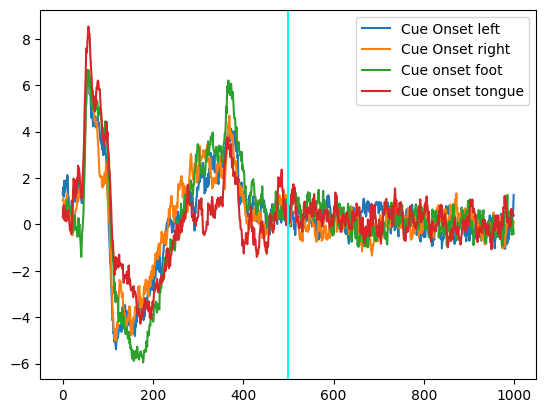

In [4]:
## Loading and visualizing the data

## Loading the dataset

X_test = np.load("X_test.npy")  # (443, 22, 1000)
y_test = np.load("y_test.npy")  # (443, 4)  # (num_trials, output types) # one hot encoded
person_train_valid = np.load("person_train_valid.npy")  # (2115, 1)  vals from 0-8 for participant
X_train_valid = np.load("X_train_valid.npy")  # (2115, 22, 1000)
# print(X_train_valid.shape)  # (2115, 22, 1000)  # (num_trials, channels, time bins)
y_train_valid = np.load("y_train_valid.npy")  # (2115,)
person_test = np.load("person_test.npy")  # (443, 1)

## Adjusting the labels so that

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

## Visualizing the data

ch_data = X_train_valid[:,8,:]


class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])

In [5]:
def train_data_prep(X,y,sub_sample,average,noise):

    total_X = None
    total_y = None

    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)

    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)


    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)

    # Averaging + noise
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)

    # Data augmentation: increases number of samples (max pool and mean pool +noise)
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)

    # Subsampling

    for i in range(sub_sample):

        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)

        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))


    print('Shape of X after subsampling and concatenating:',total_X.shape)
    print('Shape of Y:',total_y.shape)
    return total_X,total_y


# Don't increase the number of test samples
def test_data_prep(X):

    total_X = None


    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)

    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, 2), axis=3)


    total_X = X_max
    print('Shape of X after maxpooling:',total_X.shape)

    return total_X

In [6]:
# Train val split, then data augment the training set
ind_valid = np.random.choice(X_train_valid.shape[0], 1000, replace=False)
ind_train = np.array(list(set(range(X_train_valid.shape[0])).difference(set(ind_valid))))
# Creating the training and validation sets using the generated indices
(x_train_unprocessed, x_valid) = X_train_valid[ind_train], X_train_valid[ind_valid]
(y_train_unprocessed, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]

x_train, y_train = train_data_prep(x_train_unprocessed, y_train_unprocessed,2,2,True)
x_valid, y_valid = train_data_prep(x_valid, y_valid, 2, 2, True)
X_test_prep = test_data_prep(X_test)

# Old code with data leakage
## Preprocessing the dataset
# X_train_valid_prep,y_train_valid_prep = train_data_prep(X_train_valid,y_train_valid,2,2,True)
# X_test_prep = test_data_prep(X_test)
# ## Random splitting and reshaping the data
# # First generating the training and validation indices using random splitting
# # 8460 is shape of num_samples after data augmentation
# ind_valid = np.random.choice(8460, 1000, replace=False)
# ind_train = np.array(list(set(range(8460)).difference(set(ind_valid))))
# # Creating the training and validation sets using the generated indices
# (x_train, x_valid) = X_train_valid_prep[ind_train], X_train_valid_prep[ind_valid]
# (y_train, y_valid) = y_train_valid_prep[ind_train], y_train_valid_prep[ind_valid]
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)


# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_valid.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)
# Note the dims of validation are diff than originally bc no longer data augment it

Shape of X after trimming: (1115, 22, 800)
Shape of X after maxpooling: (1115, 22, 400)
Shape of X after averaging+noise and concatenating: (2230, 22, 400)
Shape of X after subsampling and concatenating: (4460, 22, 400)
Shape of Y: (4460,)
Shape of X after trimming: (1000, 22, 800)
Shape of X after maxpooling: (1000, 22, 400)
Shape of X after averaging+noise and concatenating: (2000, 22, 400)
Shape of X after subsampling and concatenating: (4000, 22, 400)
Shape of Y: (4000,)
Shape of X after trimming: (443, 22, 800)
Shape of X after maxpooling: (443, 22, 400)
Shape of training set: (4460, 22, 400)
Shape of validation set: (4000, 22, 400)
Shape of training labels: (4460,)
Shape of validation labels: (4000,)
Shape of training labels after categorical conversion: (4460, 4)
Shape of validation labels after categorical conversion: (4000, 4)
Shape of test labels after categorical conversion: (443, 4)
Shape of training set after adding width info: (4460, 22, 400, 1)
Shape of validation set af

In [7]:
input_shape = (400,1,22)

In [5]:
class ConvBlock(keras.layers.Layer):
    def __init__(self, filters, use_batchnorm=True, dropout_rate=0.6,
                 l1_reg=0.0, kernel_size=(5,5), pool_size=(3,1), input_shape=None, **kwargs):
        """Set pool_size, use_batchnorm, or dropout to None to remove them"""
        super().__init__(name="ConvBlock", **kwargs)
        self.pool_size, self.use_batchnorm, self.dropout_rate = pool_size, use_batchnorm, dropout_rate
        if input_shape == None:
            self.conv = Conv2D(filters, kernel_size, padding='same', activation='elu')
        else:
            self.conv = Conv2D(filters, kernel_size, input_shape=input_shape, padding='same', activation='elu')
        if l1_reg != 0.0:
            self.conv.kernel_regularizer = tf.keras.regularizers.L1(l1=l1_reg)
        if pool_size != None:
            self.pool = MaxPooling2D(pool_size, padding="same")
        if use_batchnorm:
            self.bn = BatchNormalization()
        if dropout_rate != None and dropout_rate != 0:
            self.dropout = Dropout(dropout_rate)

    def call(self, x):
        x = self.conv(x)
        if self.pool_size != None:
            x = self.pool(x)
        if self.use_batchnorm:
            x = self.bn(x)
        if self.dropout_rate != None and self.dropout_rate != 0:
            x = self.dropout(x)
        return x


num_classes = 4

class CNNLSTMModel(keras.Model):
    def __init__(
        self,
        input_shape,
        conv_filters=[25, 50, 100, 200],
        l1_reg=0.0,
        num_hidden=40,  # for dense before LSTM
        lstm_units=10,
        dropout_rate=0.6,
        use_batchnorm=True,
        name="CNNLSTM",
        **kwargs
    ):
        super().__init__(name="CNNLSTM", **kwargs)

        self.convblocks = []
        # self.num_conv_blocks = len(conv_filters)
        input_layer = keras.Input(shape=input_shape)
        num_conv_blocks = len(conv_filters)
        for i in range(num_conv_blocks):
            if i == 0:
                self.convblocks.append(ConvBlock(conv_filters[0], use_batchnorm, dropout_rate, l1_reg, input_shape=input_shape))
            else:
                self.convblocks.append(ConvBlock(conv_filters[i], use_batchnorm, dropout_rate, l1_reg))

        self.flatten = Flatten()
        self.dense1 = Dense((num_hidden))
        self.reshape = Reshape((num_hidden, 1))  # Reshape so that it's compatible
        self.lstm = LSTM(lstm_units, dropout=0.4, recurrent_dropout=0.1, input_shape=(num_hidden,1), return_sequences=False)
        self.out = Dense(num_classes, activation='softmax')

    def call(self, x):
        for conv in self.convblocks:
            x = conv(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.reshape(x)
        x = self.lstm(x)
        x = self.out(x)
        return x


Baseline

In [9]:
input_shape = (400, 1, 22)
# l1_term = 0  # 0.01  pass into model
model = CNNLSTMModel(input_shape=input_shape)
model.build((None, 400, 1, 22))
model.summary(expand_nested=True)

Model: "CNNLSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ConvBlock (ConvBlock)       multiple                  13875     
                                                                 
 ConvBlock (ConvBlock)       multiple                  31500     
                                                                 
 ConvBlock (ConvBlock)       multiple                  125500    
                                                                 
 ConvBlock (ConvBlock)       multiple                  501000    
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  40040     
                                                                 
 reshape (Reshape)           multiple                  0   

In [10]:
# Model parameters
num_channels = 22
l1_term = 0  # 0.01  pass into model
lr = 1e-3
NUM_EPOCHS = 100
batch_size = 64
patience = 5  # 3
criterion="categorical_crossentropy"
optimizer = keras.optimizers.Adam(learning_rate=lr)
callbacks = []

# Compiling the model
# early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

if USING_WANDB:
    wandb.init(
        project="EEG-ml",
        name="baseline",  # i like to put a note about the current run here (e.g lr-.001 or something)
        settings=wandb.Settings(start_method="fork"),
        config = {
            "architecture": model.__class__.__name__,
            "epochs": NUM_EPOCHS,
            "learning_rate": lr,
            "batch_size": batch_size,
            "optimizer": optimizer.__class__.__name__,
            "loss fn": criterion.__class__.__name__,
            "patience": patience
            # "weight decay": weight_decay,
    })

    callbacks.append(WandbMetricsLogger())

model.compile(loss=criterion,
                optimizer=optimizer,
                metrics=['accuracy'])

# Training and validating the model
model_results = model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=NUM_EPOCHS, callbacks=callbacks,
            validation_data=(x_valid, y_valid), verbose=0)  #, verbose=True)

model_score = model.evaluate(x_test, y_test, verbose=0)
test_acc = model_score[1]
print('Test accuracy of the Base line hybrid CNN-LSTM model:', test_acc)
if USING_WANDB:
    wandb.summary["Test_Acc"] = test_acc
    wandb.finish()

wandb: Currently logged in as: petern0408. Use `wandb login --relogin` to force relogin


Test accuracy of the Base line hybrid CNN-LSTM model: 0.6252821683883667


epoch/accuracy,▁▂▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇██████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,██▇▇▆▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▂▂▃▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇███
epoch/val_loss,▇▇█▆▄▃▃▃▃▂▂▃▁▂▂▂▁▂▂▃▂▃▁▂▂▃▃▂▂▂▃▃▂▂▃▂▃▂▂▂
Test_Acc,0.62528
epoch/accuracy,0.80224
epoch/epoch,99
epoch/learning_rate,0.001
epoch/loss,0.51252


In [ ]:
# def sweep_func(config=None):
#     with wandb.init(config=config):
#         config = wandb.config
#         input_shape = (400, 1, 22)
#         num_channels = 22
#         l1_term = 0  # 0.01  pass into model
#         lr = 1e-3
#         NUM_EPOCHS = 100
#         batch_size = 64
#         patience = 5  # 3

#         optimizer = keras.optimizers.Adam(learning_rate=lr)
#         model = CNNLSTMModel(input_shape, config.conv_filters, config.l1_reg,
#                              config.num_hidden, config.lstm_units, config.dropout_rate,
#                              config.use_batchnorm)  # (400, 1, num_channels)

#         callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)]

#         if USING_WANDB:
#             wandb.init(
#                 project="EEG-ml",
#                 name="sweep",
#                 settings=wandb.Settings(start_method="fork"),
#                 config = {
#                     "architecture": model.__class__.__name__,
#                     "epochs": NUM_EPOCHS,
#                     "learning_rate": lr,
#                     "batch_size": batch_size,
#                     "optimizer": optimizer.__class__.__name__,
#                     "loss fn": criterion.__class__.__name__,
#                     "patience": patience
#                     # "weight decay": weight_decay,
#             })

#             callbacks.append(WandbMetricsLogger())

#             model.compile(loss=criterion, optimizer=optimizer, metrics=['accuracy'])

#             model_results = model.fit(temp_x_train, y_train, batch_size, NUM_EPOCHS,
#                 callbacks=callbacks, validation_data=(temp_x_valid, y_valid), verbose=0)

#             model_score = model.evaluate(temp_x_test, y_test, verbose=0)
#             test_acc = model_score[1]
#             print('Test accuracy of the hybrid CNN-LSTM model:', test_acc)

#             if USING_WANDB:
#                 wandb.summary["Test_Acc"] = test_acc
#                 wandb.finish()

Experiment with training by removing each channel

In [ ]:
num_channels = 22
l1_term = 0  # 0.01  pass into model
lr = 1e-3
NUM_EPOCHS = 100
batch_size = 64
patience = 5  # 3

test_accs_per_channel = []

for c in range(num_channels + 1):
    if c != num_channels:
        print(f"SKIPPING channel {c} (0-indexed)")
        temp_x_train = np.delete(x_train, c, axis=3)  # (4460, 400, 1, 21)
        temp_x_valid = np.delete(x_valid, c, axis=3)
        temp_x_test = np.delete(x_test, c, axis=3)
        input_shape = (400, 1, num_channels - 1)  # removed a dim
    else:
        print(f"Using all Channels")
        input_shape = (400, 1, num_channels)
    # keep same y labels

    optimizer = keras.optimizers.Adam(learning_rate=lr)
    criterion="categorical_crossentropy"

    # Compiling the model
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)]

    model = CNNLSTMModel(input_shape=input_shape)

    if c != num_channels:
        run_name = f"delete-{c}-channel"
    else:
        run_name = f"all-channels"

    if USING_WANDB:
        wandb.init(
            project="EEG-ml",
            name=run_name,  # i like to put a note about the current run here (e.g lr-.001 or something)
            settings=wandb.Settings(start_method="fork"),
            config = {
                "architecture": model.__class__.__name__,
                "epochs": NUM_EPOCHS,
                "learning_rate": lr,
                "batch_size": batch_size,
                "optimizer": optimizer.__class__.__name__,
                "loss fn": criterion.__class__.__name__,
                "patience": patience
                # "weight decay": weight_decay,
        })

        callbacks.append(WandbMetricsLogger())

    model.compile(loss=criterion,
                    optimizer=optimizer,
                    metrics=['accuracy'])

    # Training and validating the model
    model_results = model.fit(temp_x_train, y_train,
                batch_size=batch_size,
                epochs=NUM_EPOCHS, callbacks=callbacks,
                validation_data=(temp_x_valid, y_valid), verbose=0)  #, verbose=True)

    model_score = model.evaluate(temp_x_test, y_test, verbose=0)
    test_acc = model_score[1]
    print('Test accuracy of the hybrid CNN-LSTM model:', test_acc)
    test_accs_per_channel.append(test_acc)
    if USING_WANDB:
        wandb.summary["Test_Acc"] = test_acc
        wandb.finish()

SKIPPING channel 0 (0-indexed)


epoch/accuracy,▁▁▂▃▃▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████
epoch/epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,██▇▇▇▆▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁
epoch/val_accuracy,▁▃▃▃▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇███▇██████
epoch/val_loss,██▇▇▅▅▄▄▄▄▃▃▃▂▂▃▂▂▂▂▃▂▂▂▂▃▁▂▁▂▁▁▂▁▂▂
epoch/accuracy,0.69215
epoch/epoch,35
epoch/learning_rate,0.001
epoch/loss,0.79318
epoch/val_accuracy,0.57325


Test accuracy of the hybrid CNN-LSTM model: 0.45598194003105164


epoch/accuracy,▁▃▃▄▅▅▅▆▆▆▆▇▆▇▇▇▇▇▇▇▇████
epoch/epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,██▇▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▁▁▁
epoch/val_accuracy,▁▃▅▆▆▇▆▆▇▆▇▅▅▆▆▇▇▇▇█▇▇▇▇█
epoch/val_loss,█▇▆▅▅▃▄▃▃▄▃▃▄▃▄▃▂▁▂▁▂▂▂▂▂
Test Acc,0.45598
epoch/accuracy,0.56143
epoch/epoch,24
epoch/learning_rate,0.001
epoch/loss,1.00137


SKIPPING channel 1 (0-indexed)


Test accuracy of the hybrid CNN-LSTM model: 0.45372459292411804


epoch/accuracy,▁▃▃▅▆▅▆▆▆▆▇▇▇▇▇▇███████
epoch/epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▇▆▅▅▄▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁
epoch/val_accuracy,▁▃▄▅▆▅▆▅▅▅▆▆▆▆▇▇▆▇▇▇███
epoch/val_loss,█▇▅▅▄▅▄▅▄▃▃▃▂▃▂▂▃▁▂▂▁▁▂
Test Acc,0.45372
epoch/accuracy,0.54395
epoch/epoch,22
epoch/learning_rate,0.001
epoch/loss,1.03068


SKIPPING channel 2 (0-indexed)


Test accuracy of the hybrid CNN-LSTM model: 0.45823928713798523


epoch/accuracy,▁▂▃▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇████
epoch/epoch,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▇▆▆▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁
epoch/val_accuracy,▁▃▃▄▅▇▆▆▆▇▆▇▇▇█▇▅███▇███
epoch/val_loss,█▇▆▇▄▃▃▃▃▂▃▂▁▂▂▂▄▁▁▁▂▂▂▂
Test Acc,0.45824
epoch/accuracy,0.56682
epoch/epoch,23
epoch/learning_rate,0.001
epoch/loss,1.0021


SKIPPING channel 3 (0-indexed)


Test accuracy of the hybrid CNN-LSTM model: 0.44695258140563965


epoch/accuracy,▁▂▃▄▅▅▆▆▆▆▆▇▇▇▇█████
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,██▇▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁
epoch/val_accuracy,▁▁▁▂▅▅▆▇▇▇▇▇▇███▇▇█▇
epoch/val_loss,██▇▇▅▆▄▃▃▃▂▂▂▂▁▁▃▂▂▂
Test Acc,0.44695
epoch/accuracy,0.55471
epoch/epoch,19
epoch/learning_rate,0.001
epoch/loss,1.0407


SKIPPING channel 4 (0-indexed)


Test accuracy of the hybrid CNN-LSTM model: 0.5214446783065796


epoch/accuracy,▁▂▃▃▄▄▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇█████
epoch/epoch,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▇▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▂▁▁
epoch/val_accuracy,▁▃▄▄▂▄▄▄▆▆▆▇▇▆▇▇▆██▇█▇█████▇█
epoch/val_loss,█▆▆▆▆▅▅▄▃▃▄▂▂▃▂▂▃▂▂▂▂▃▂▁▂▂▁▃▂
Test Acc,0.52144
epoch/accuracy,0.60964
epoch/epoch,28
epoch/learning_rate,0.001
epoch/loss,0.9282


SKIPPING channel 5 (0-indexed)


Test accuracy of the hybrid CNN-LSTM model: 0.48758465051651


epoch/accuracy,▁▂▃▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇█▇▇██████
epoch/epoch,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,██▇▆▆▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁
epoch/val_accuracy,▁▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇█████▇█
epoch/val_loss,█▇▆▅▄▄▃▄▃▃▃▂▂▃▂▃▂▂▂▂▁▂▂▁▁▁▁▂▁
Test Acc,0.48758
epoch/accuracy,0.59484
epoch/epoch,28
epoch/learning_rate,0.001
epoch/loss,0.95831


SKIPPING channel 6 (0-indexed)


Test accuracy of the hybrid CNN-LSTM model: 0.4898419976234436


epoch/accuracy,▁▂▃▃▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████
epoch/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,██▇▇▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁
epoch/val_accuracy,▁▂▃▄▅▄▅▆▅▅▅▅▆▄▆▆▆▆▇▅▆▇▆▆▆▇▇▇▇▆▆▇▇▇▇▇▇▇▇█
epoch/val_loss,█▇▇▆▅▄▄▃▄▃▃▃▃▄▃▂▂▂▂▃▂▂▂▂▂▂▂▂▂▃▂▁▂▂▂▁▁▂▃▂
Test Acc,0.48984
epoch/accuracy,0.60762
epoch/epoch,40
epoch/learning_rate,0.001
epoch/loss,0.8889


SKIPPING channel 7 (0-indexed)


Test accuracy of the hybrid CNN-LSTM model: 0.46726861596107483


epoch/accuracy,▁▂▂▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
epoch/epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,██▇▆▆▅▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁
epoch/val_accuracy,▁▁▂▃▅▆▆▆▆▇▆▇▆▆▆██▇▇█▇
epoch/val_loss,█▇▆▆▄▃▃▃▃▃▃▂▃▄▂▁▁▂▂▁▁
Test Acc,0.46727
epoch/accuracy,0.56951
epoch/epoch,20
epoch/learning_rate,0.001
epoch/loss,1.01528


SKIPPING channel 8 (0-indexed)


Test accuracy of the hybrid CNN-LSTM model: 0.43792325258255005


epoch/accuracy,▁▃▄▅▆▆▆▇▇▇▇▇██
epoch/epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▅▅▄▄▃▃▂▂▂▁▁
epoch/val_accuracy,▁▃▆▆▆▇▇▇█▇▆▇▇▇
epoch/val_loss,█▅▄▄▄▂▂▂▁▁▃▁▂▁
Test Acc,0.43792
epoch/accuracy,0.50987
epoch/epoch,13
epoch/learning_rate,0.001
epoch/loss,1.10839


SKIPPING channel 9 (0-indexed)


Test accuracy of the hybrid CNN-LSTM model: 0.4830699861049652


epoch/accuracy,▁▂▃▄▄▅▆▆▆▆▇▇▇▇▇▇▇▇███
epoch/epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,██▇▆▆▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁
epoch/val_accuracy,▁▃▅▅▆▆▇▇██▇█▇████████
epoch/val_loss,██▇▅▅▄▃▃▃▂▃▂▂▁▂▁▁▁▂▂▁
Test Acc,0.48307
epoch/accuracy,0.54126
epoch/epoch,20
epoch/learning_rate,0.001
epoch/loss,1.05526


SKIPPING channel 10 (0-indexed)


Test accuracy of the hybrid CNN-LSTM model: 0.43792325258255005


epoch/accuracy,▁▃▄▅▆▆▆▇▇▇▇█▇███
epoch/epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▅▅▄▄▃▃▃▂▂▂▂▁▁
epoch/val_accuracy,▁▆▆▆▇█▇▇▇▇▇▇▇▇▇▇
epoch/val_loss,█▆▄▄▂▁▃▁▂▂▁▂▂▂▂▁
Test Acc,0.43792
epoch/accuracy,0.53206
epoch/epoch,15
epoch/learning_rate,0.001
epoch/loss,1.06454


SKIPPING channel 11 (0-indexed)


Test accuracy of the hybrid CNN-LSTM model: 0.4762979745864868


epoch/accuracy,▁▂▃▄▄▅▅▆▆▆▆▇▇▇▇▇▇███
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▇▆▆▅▅▄▄▄▃▃▃▃▂▂▂▂▁▁
epoch/val_accuracy,▁▃▄▆▆▇▇▅▆▇█▅▇█▇▇▇▇█▇
epoch/val_loss,█▇▅▄▄▃▂▃▃▃▂▄▁▁▁▁▁▃▂▁
Test Acc,0.4763
epoch/accuracy,0.54238
epoch/epoch,19
epoch/learning_rate,0.001
epoch/loss,1.04528


SKIPPING channel 12 (0-indexed)


Test accuracy of the hybrid CNN-LSTM model: 0.4853273034095764


epoch/accuracy,▁▂▃▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇███
epoch/epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,██▇▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁
epoch/val_accuracy,▁▃▄▅▅▆▆▆▆▆▅▆▆▆▇▆▆▆▇▆█▇█▆█▇██
epoch/val_loss,█▇▆▄▄▄▃▃▃▃▃▃▃▃▃▂▃▃▃▃▁▂▁▃▁▂▁▂
Test Acc,0.48533
epoch/accuracy,0.58722
epoch/epoch,27
epoch/learning_rate,0.001
epoch/loss,0.96467


SKIPPING channel 13 (0-indexed)


Test accuracy of the hybrid CNN-LSTM model: 0.44920992851257324


epoch/accuracy,▁▂▄▄▅▆▆▆▇▆▇▇▇▇▇███
epoch/epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▆▅▅▄▄▃▃▃▃▂▂▂▁▁▁
epoch/val_accuracy,▁▂▃▅▆▆▆▇▅▇█▇▇▇▇▇██
epoch/val_loss,█▇▆▄▄▃▄▂▅▃▂▂▁▂▁▁▁▂
Test Acc,0.44921
epoch/accuracy,0.53565
epoch/epoch,17
epoch/learning_rate,0.001
epoch/loss,1.05557


SKIPPING channel 14 (0-indexed)


Test accuracy of the hybrid CNN-LSTM model: 0.4830699861049652


epoch/accuracy,▁▂▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇█▇████
epoch/epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,██▇▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁
epoch/val_accuracy,▁▃▅▆▇▆▇▇▆▇▇▆▆▇▇▆▇██▇▇▇▇
epoch/val_loss,█▇▆▅▄▄▃▃▃▃▃▃▄▃▃▃▂▁▂▂▂▂▂
Test Acc,0.48307
epoch/accuracy,0.56054
epoch/epoch,22
epoch/learning_rate,0.001
epoch/loss,0.99377


SKIPPING channel 15 (0-indexed)


Test accuracy of the hybrid CNN-LSTM model: 0.4650112986564636


epoch/accuracy,▁▂▃▃▄▄▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█▇██
epoch/epoch,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▇▇▆▆▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
epoch/val_accuracy,▁▁▃▄▄▄▄▄▄▄▅▅▇▆▇▆▇▇▇▇█▇▇███▇▇▇
epoch/val_loss,█▇▇▆▆▆▅▅▄▅▃▄▂▂▂▃▂▂▁▁▁▂▂▁▁▂▃▄▃
Test Acc,0.46501
epoch/accuracy,0.58924
epoch/epoch,28
epoch/learning_rate,0.001
epoch/loss,0.9563


SKIPPING channel 16 (0-indexed)


Test accuracy of the hybrid CNN-LSTM model: 0.4898419976234436


epoch/accuracy,▁▂▃▄▄▅▅▆▆▆▆▇▇▇▇▇▇▇█████
epoch/epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,██▇▇▆▅▅▄▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁
epoch/val_accuracy,▂▁▃▅▆▆▆▆▆▆▇▇▆▇▇█▇█▇▇▇██
epoch/val_loss,▇█▆▅▄▄▃▃▃▃▂▃▄▂▃▂▂▁▃▃▃▂▁
Test Acc,0.48984
epoch/accuracy,0.58789
epoch/epoch,22
epoch/learning_rate,0.001
epoch/loss,0.98414


SKIPPING channel 17 (0-indexed)


Test accuracy of the hybrid CNN-LSTM model: 0.4808126389980316


epoch/accuracy,▁▂▃▃▄▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█▇█████
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,██▇▆▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
epoch/val_accuracy,▁▂▄▅▅▅▆▆▆▆▆▇▆▆▇▆▇▇█▆▇▇██▇▇▇█▇████
epoch/val_loss,█▇▅▅▄▅▄▄▄▃▃▃▂▃▂▂▂▂▁▂▂▂▁▁▂▁▂▁▂▂▁▂▂
Test Acc,0.48081
epoch/accuracy,0.58677
epoch/epoch,32
epoch/learning_rate,0.001
epoch/loss,0.949


SKIPPING channel 18 (0-indexed)


Test accuracy of the hybrid CNN-LSTM model: 0.44695258140563965


epoch/accuracy,▁▂▃▄▅▅▆▆▇▇▇▇██████
epoch/epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,██▇▆▅▅▄▄▃▃▃▂▂▂▂▂▁▁
epoch/val_accuracy,▁▂▃▄▆▇▅▆▆▇▇██▇▇███
epoch/val_loss,█▇▇▇▅▃▅▃▂▃▂▁▁▂▂▂▁▂
Test Acc,0.44695
epoch/accuracy,0.53408
epoch/epoch,17
epoch/learning_rate,0.001
epoch/loss,1.0681


SKIPPING channel 19 (0-indexed)


Test accuracy of the hybrid CNN-LSTM model: 0.45146727561950684


epoch/accuracy,▁▂▃▃▄▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
epoch/epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,██▇▇▆▆▅▅▅▄▄▄▃▃▃▂▃▂▂▂▂▁▁
epoch/val_accuracy,▁▂▂▄▅▆▆▇▆▆█▇▇▇▇▆▇█▇█▇▇▇
epoch/val_loss,██▇▇▅▄▄▃▄▃▂▃▂▂▂▃▃▁▂▁▂▂▂
Test Acc,0.45147
epoch/accuracy,0.55605
epoch/epoch,22
epoch/learning_rate,0.001
epoch/loss,1.01521


SKIPPING channel 20 (0-indexed)


Test accuracy of the hybrid CNN-LSTM model: 0.42437922954559326


epoch/accuracy,▁▃▄▅▆▆▆▇▇▇▇████
epoch/epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▅▄▄▃▃▃▂▂▂▂▁▁
epoch/val_accuracy,▁▅▇▇███▇▆▇▇▇▆█▇
epoch/val_loss,█▆▄▃▁▁▁▁▂▁▂▂▂▂▁
Test Acc,0.42438
epoch/accuracy,0.5278
epoch/epoch,14
epoch/learning_rate,0.001
epoch/loss,1.09036


SKIPPING channel 21 (0-indexed)


In [ ]:
# test_accs_per_channel
# plot

In [ ]:
# Model parameters
# USING_WANDB = True
lr = 1e-3
NUM_EPOCHS = 100
batch_size = 64

optimizer = keras.optimizers.Adam(learning_rate=lr)
criterion="categorical_crossentropy"

# TURNED OFF early stopping for now
# Compiling the model
patience = 5  # 3
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)]

input_shape = (400, 1, 22)
l1_term = 0  # 0.01  pass into model
model = CNNLSTMModel(input_shape=input_shape)

if USING_WANDB:
    wandb.init(
        project="EEG-ml",
        name=f"basic",  # i like to put a note about the current run here (e.g lr-.001 or something)
        settings=wandb.Settings(start_method="fork"),
        config = {
            "architecture": model.__class__.__name__,
            "epochs": NUM_EPOCHS,
            "learning_rate": lr,
            "batch_size": batch_size,
            "optimizer": optimizer.__class__.__name__,
            "loss fn": criterion.__class__.__name__,
            "patience": patience
            # "weight decay": weight_decay,
    })

    callbacks.append(WandbMetricsLogger())


model.compile(loss=criterion,
                 optimizer=optimizer,
                 metrics=['accuracy'])

# Training and validating the model
model_results = model.fit(x_train, y_train,
             batch_size=batch_size,
             epochs=NUM_EPOCHS, callbacks=callbacks,
             validation_data=(x_valid, y_valid))  #, verbose=True)

model_score = model.evaluate(x_test, y_test, verbose=0)
test_acc = model_score[1]
print('Test accuracy of the hybrid CNN-LSTM model:', test_acc)
if USING_WANDB:
    wandb.summary["Test Acc"] = test_acc
    wandb.finish()

Epoch 1/100
70/70 [==============================] - 32s 390ms/step - loss: 1.3891 - accuracy: 0.2581 - val_loss: 1.3840 - val_accuracy: 0.3113
Epoch 2/100
70/70 [==============================] - 25s 365ms/step - loss: 1.3740 - accuracy: 0.2935 - val_loss: 1.3480 - val_accuracy: 0.3260
Epoch 3/100
70/70 [==============================] - 27s 381ms/step - loss: 1.3437 - accuracy: 0.3417 - val_loss: 1.3428 - val_accuracy: 0.3638
Epoch 4/100
70/70 [==============================] - 27s 390ms/step - loss: 1.2986 - accuracy: 0.3800 - val_loss: 1.2931 - val_accuracy: 0.3647
Epoch 5/100
70/70 [==============================] - 26s 365ms/step - loss: 1.2655 - accuracy: 0.4052 - val_loss: 1.2693 - val_accuracy: 0.3725
Epoch 6/100
70/70 [==============================] - 31s 439ms/step - loss: 1.2491 - accuracy: 0.4173 - val_loss: 1.2313 - val_accuracy: 0.4300
Epoch 7/100
70/70 [==============================] - 27s 381ms/step - loss: 1.2199 - accuracy: 0.4500 - val_loss: 1.2087 - val_accuracy:

epoch/accuracy,▁▂▃▄▄▄▅▅▅▅▅▆▆▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,██▇▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
epoch/val_accuracy,▁▂▄▅▅▅▅▆▅▆▆▅▆▆▇▆▇▇▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇██████
epoch/val_loss,█▇▄▃▂▃▂▁▄▁▁▃▂▁▁▂▁▁▂▄▁▂▁▂▂▁▁▁▂▂▁▃▁▅▃▁▁▂▃▃
epoch/accuracy,0.77085
epoch/epoch,99
epoch/learning_rate,0.001
epoch/loss,0.59442
epoch/val_accuracy,0.5865


Experiment with L1 Reg  (TODO: move this to new notebook)

In [ ]:
# WITH L1 REG

# Building the CNN model using sequential class
hybrid_cnn_lstm_model = Sequential()

# Conv. block 1
# val_accuracy: 0.4618  w/ default .01 TODO implement early stopping
l1_term = .001
l1_reg = tf.keras.regularizers.L1(l1=l1_term)
print(f"USING {l1_term} l1_term")

hybrid_cnn_lstm_model.add(Conv2D(filters=25, kernel_size=(5,5), padding='same', activation='elu', input_shape=input_shape,
                                 kernel_regularizer=l1_reg))  # ADDED L1 reg
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.6))

# Conv. block 2
hybrid_cnn_lstm_model.add(Conv2D(filters=50, kernel_size=(5,5), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.6))

# Conv. block 3
hybrid_cnn_lstm_model.add(Conv2D(filters=100, kernel_size=(5,5), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.6))

# Conv. block 4
hybrid_cnn_lstm_model.add(Conv2D(filters=200, kernel_size=(5,5), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.6))

# FC+LSTM layers
hybrid_cnn_lstm_model.add(Flatten()) # Adding a flattening operation to the output of CNN block
hybrid_cnn_lstm_model.add(Dense((40))) # FC layer
hybrid_cnn_lstm_model.add(Reshape((40,1))) # Reshape my output of FC layer so that it's compatible
hybrid_cnn_lstm_model.add(LSTM(10, dropout=0.4, recurrent_dropout=0.1, input_shape=(40,1), return_sequences=False))
# TODO: can make the 3rd dim more than just 1. could make it a feature vector

# Output layer with Softmax activation
hybrid_cnn_lstm_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation

# Printing the model summary
hybrid_cnn_lstm_model.summary()

USING 0.001 l1_term
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_45 (Conv2D)          (None, 400, 1, 25)        13775     
                                                                 
 max_pooling2d_39 (MaxPooli  (None, 134, 1, 25)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_39 (Ba  (None, 134, 1, 25)        100       
 tchNormalization)                                               
                                                                 
 dropout_39 (Dropout)        (None, 134, 1, 25)        0         
                                                                 
 conv2d_46 (Conv2D)          (None, 134, 1, 50)        31300     
                                                                 
 max_pooling2d_40 (MaxPooli  (None

In [ ]:
# Model parameters
learning_rate = 1e-3
epochs = 100
hybrid_cnn_lstm_optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

# Compiling the model
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

hybrid_cnn_lstm_model.compile(loss='categorical_crossentropy',
                 optimizer=hybrid_cnn_lstm_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
hybrid_cnn_lstm_model_results = hybrid_cnn_lstm_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs, callbacks=[early_stop_callback],
             validation_data=(x_valid, y_valid), verbose=True)

Epoch 1/100
70/70 [==============================] - 31s 370ms/step - loss: 1.6268 - accuracy: 0.2578 - val_loss: 1.4777 - val_accuracy: 0.2765
Epoch 2/100
70/70 [==============================] - 30s 430ms/step - loss: 1.4585 - accuracy: 0.2915 - val_loss: 1.4322 - val_accuracy: 0.3428
Epoch 3/100
70/70 [==============================] - 26s 372ms/step - loss: 1.4171 - accuracy: 0.3390 - val_loss: 1.3704 - val_accuracy: 0.3985
Epoch 4/100
70/70 [==============================] - 25s 359ms/step - loss: 1.3692 - accuracy: 0.3807 - val_loss: 1.3050 - val_accuracy: 0.4387
Epoch 5/100
70/70 [==============================] - 25s 359ms/step - loss: 1.3374 - accuracy: 0.3964 - val_loss: 1.3411 - val_accuracy: 0.3823
Epoch 6/100
70/70 [==============================] - 26s 373ms/step - loss: 1.3148 - accuracy: 0.4191 - val_loss: 1.2908 - val_accuracy: 0.4123
Epoch 7/100
70/70 [==============================] - 26s 372ms/step - loss: 1.2981 - accuracy: 0.4148 - val_loss: 1.2630 - val_accuracy:

In [ ]:
# Checking L1 regularization results
# check feature map sparcity (percent of )
# consider gradient based saliency map ?
num_channels = 22
threshold = 1e-7  # below this number we consider 0 weight

hidden1_params = hybrid_cnn_lstm_model.layers[0].get_weights()
# print(hidden1_params[0].shape)
# print(hidden1_params[1].shape)  # biases: (25,)  # num_filters
hidden1_weights_abs = tf.math.abs(hidden1_params[0])  # (5, 5, 22, 25)  # (w,h, num_channels, num_filters)
mean_weight_val = tf.math.reduce_mean(hidden1_weights_abs)
sd_weight_val = tf.math.reduce_std(hidden1_weights_abs)
print(f"Total: mean {mean_weight_val :.7f}, sd {sd_weight_val :.6f}")

for c in range (num_channels):
    print(f"Channel {c}")
    hidden1_weights_abs_c = hidden1_weights_abs[:, :, c, :]  # (5,5,25)
    mean_weight_val = tf.math.reduce_mean(hidden1_weights_abs_c)
    sd_weight_val = tf.math.reduce_std(hidden1_weights_abs_c)
    print(f"mean {mean_weight_val :.7f}, sd {sd_weight_val :.6f}")

    trues_mask = tf.cast((hidden1_weights_abs_c < threshold), tf.int64)  # (5, 5, 22, 25)
    bincounts = tf.math.bincount(trues_mask)
    falses = bincounts[0]
    if len(bincounts) > 1:
        trues = bincounts[1]
    else:
        trues = tf.zeros_like(falses)
    total = falses + trues
    trues_percent = tf.get_static_value(trues / total) * 100
    print(f"trues {trues}")
    print(f"trues_percent {trues_percent: .4f} %  (num of 'zeros' / num params) * 100 ")
    print()

# Channel 14
# mean 0.0006833, sd 0.001889
# channels 14, 2, 8, 10, 11, 15, 19, 21
# tried with another rate. got diff results
# trues_percent  0.1600 %  (num of 'zeros' / num params) * 100

Total: mean 0.0030221, sd 0.009854
Channel 0
mean 0.0041676, sd 0.012289
trues 0
trues_percent  0.0000 %  (num of 'zeros' / num params) * 100 

Channel 1
mean 0.0030874, sd 0.009811
trues 0
trues_percent  0.0000 %  (num of 'zeros' / num params) * 100 

Channel 2
mean 0.0019843, sd 0.005817
trues 0
trues_percent  0.0000 %  (num of 'zeros' / num params) * 100 

Channel 3
mean 0.0038470, sd 0.011239
trues 2
trues_percent  0.3200 %  (num of 'zeros' / num params) * 100 

Channel 4
mean 0.0023482, sd 0.006847
trues 0
trues_percent  0.0000 %  (num of 'zeros' / num params) * 100 

Channel 5
mean 0.0027062, sd 0.007990
trues 0
trues_percent  0.0000 %  (num of 'zeros' / num params) * 100 

Channel 6
mean 0.0037016, sd 0.011667
trues 2
trues_percent  0.3200 %  (num of 'zeros' / num params) * 100 

Channel 7
mean 0.0033583, sd 0.009868
trues 2
trues_percent  0.3200 %  (num of 'zeros' / num params) * 100 

Channel 8
mean 0.0017674, sd 0.005312
trues 0
trues_percent  0.0000 %  (num of 'zeros' / num 

In [ ]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(hybrid_cnn_lstm_model_results.history['accuracy'])
plt.plot(hybrid_cnn_lstm_model_results.history['val_accuracy'])
plt.title('Hybrid CNN-LSTM model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(hybrid_cnn_lstm_model_results.history['loss'],'o')
plt.plot(hybrid_cnn_lstm_model_results.history['val_loss'],'o')
plt.title('Hybrid CNN-LSTM model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
## Testing the hybrid CNN-LSTM model

hybrid_cnn_lstm_score = hybrid_cnn_lstm_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the hybrid CNN-LSTM model:',hybrid_cnn_lstm_score[1])
# original: 0.5778781175613403
# with .01 L1: 0.4018058776855469
# with .001 L1: 0.43340858817100525

Test accuracy of the hybrid CNN-LSTM model: 0.43340858817100525


In [ ]:
# # class SkipConnection(keras.layers.Layer):  # consider for later
# # TODO
# mlp_model = Sequential(
#     Dense(64, activation="relu", input_shape=input_shape),
#     # Reshape((32,1)),
#     Dense(32, activation="relu")
# )

# mlp_model(x_train[0])

# # Model parameters
# learning_rate = 1e-3
# epochs = 100
# mlp_optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

# # Compiling the model
# mlp_model.compile(loss='categorical_crossentropy',
#                  optimizer=mlp_optimizer,
#                  metrics=['accuracy'])

# # Training and validating the model
# mlp_model_results = mlp_model.fit(x_train,
#              y_train,
#              batch_size=64,
#              epochs=epochs,
#              validation_data=(x_valid, y_valid), verbose=True)


# # Look into L1 regularization
# first_layer_weights = model.layers[0].get_weights()[0]
# first_layer_biases  = model.layers[0].get_weights()[1]
# # second_layer_weights = model.layers[1].get_weights()[0]
# # second_layer_biases  = model.layers[1].get_weights()[1]
# print(first_layer_weights)
# print(first_layer_weights == 0)